# **The power of auto-encoders**

---



## **Introduction**

With this mini project we wanted to dive into the world of autoencoders. We hope that thanks to it you will understand how they work and what we can do with them.

An autoencoder is a type of neural network that is designed to reconstruct its input data by learning a compressed representation of the input data, known as the latent representation. This latent representation is typically a lower-dimensional space compared to the input data, and it is encoded in a latent vector.  The autoencoder has two components: an encoder and a decoder. The encoder takes the input image and maps it to the latent space. The decoder takes the latent vector associated to this image and maps it back to the original space, reconstructing a new image, similar to the input one.

The goal of the auto-encoder is to learn a good latent representation of the input data such that the reconstructed data is as close as possible to the original data. 

To clarify, an auto-encoder works like an image compression process.

Image compression : We take an image and we compress it using an encoding scheme that reduces its memory cost. Finally, we can decode the compress version of the image to obtain a new image similar to the original one.

Auto-encoder : We have an input image that pass through the 'encoder', the first part of the auto-encoder. This part is made of neural network layers that output a low dimensionality vector called the latent vector. This vector is a compress version of the input image. From this latent vector, the 'decoder' part tries reconstruct the input image.

When we train an auto-encoder, we fixe the dimension of the latent space, that is the length of the latent vector.
At the begining, the output image is totally different from the input image (all the weights of the model have a random value). But, epoch after epoch, the model will build a better low-dimensionality representation of the input image.
An auto-encoder uses unsupervised learning. We just give a dataset of images as input. No label are necessary. The precision of the model (or the loss function) is basically the difference between the output and the input images.

In the first part of this project we want to compress images and we test three different configuration using NN and CNN.

We then try to denoise images using the previous compression model.

Finally, we show a nice use of the latent space, by transfering the style of an image to another.

## **Dataset importation**

As in many laboratories and projects, we are using the MNIST dataset. It contains 70000 images of handwritten digits between 0 and 9. The size of the images is 28x28. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import progressbar
import time
from sklearn.model_selection import train_test_split 
import keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import copy
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import functools
import os
from matplotlib import gridspec
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub



In [2]:
mnist = fetch_openml('mnist_784') #You can also use and test mnist_784 or Fashion-MNIST dataset  

Basic handling of the dataset. Nothing really interesting here.

In [3]:

datasetLength = int((len(mnist['data'])))

datasetTargets  = mnist['target'][0:datasetLength]
datasetData = mnist['data'].to_numpy()[:datasetLength]
nb_classes = 10 

ratioTest = 0.2

X_train, X_test, y_train, y_test = train_test_split(datasetData, datasetTargets, test_size=ratioTest)

#Normalization   
X_train = X_train.astype('float32')/255
X_test  = X_test.astype('float32')/255

#Reshaping from the 28x28 images to array of length 784
X_train  = X_train.reshape(len(X_train), 784)  
X_test   = X_test.reshape(len(X_test), 784)

#Binary matrix representation for the label (the digit) instead of an integer
Y_train = keras.utils.np_utils.to_categorical(y_train, nb_classes)
Y_test = keras.utils.np_utils.to_categorical(y_test, nb_classes)


Here are some images of the dataset :

(<Figure size 100x100 with 1 Axes>,
 (0.0, 1.0, 0.0, 1.0),
 <matplotlib.image.AxesImage at 0x28ec0590d00>)

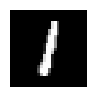

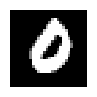

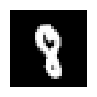

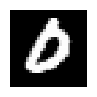

In [4]:
plt.figure(figsize=(1,1)), plt.axis("off"), plt.gray(), plt.matshow(X_train[42].reshape(28, 28), fignum=0)
plt.figure(figsize=(1,1)), plt.axis("off"), plt.matshow(X_train[85].reshape(28, 28), fignum=0)
plt.figure(figsize=(1,1)), plt.axis("off"), plt.matshow(X_train[64].reshape(28, 28), fignum=0)
plt.figure(figsize=(1,1)), plt.axis("off"), plt.matshow(X_train[850].reshape(28, 28), fignum=0)

## **Auto-encoder using one dense layer**


Here we build the auto-encoder.
A dense layer is a fully connected layer.
We use one dense layer for the encoder part, and one for the decoder part.

In [5]:
# Input data size
original_dim = 784

## Hyperparameters ##

# We will try different size of the latent space. One image will be associated to one vector of the dimension of the latent space. This vector is the compress version of this image.
# The compression ratio of our model is then directly corelated to this value.
latent_dims = [8,16,32,64] # We use the letter z to refer to the value. '32' is at the end so that the variables like 'encoder' could be use after, with z=32.

# Training parameters :
# We have a training dataset with 56000 images (80% of 70000). With a batch size of 250 and 80 epochs, our dataset will be divided into 224 batches, each with 250 images.
# The weights of the model are updated after each batch. Thus, one epoch correspond to 224 batches or 224 updates of the model.
# The model will be exposed to the whole training dataset 80 times, which corresponds to a total of 17920 batches.
# We will see during the next parts of this project that the model is pretty robust. To tune those training hyperparameters is not really relevant.

epochs=80
batch_size=250

## Building of each model, layer by layer ##
models = {}
for latent_dim in latent_dims:
    models[latent_dim] = {}
    
    input_img = Input(shape=(original_dim,))

    encoder_layer = Dense(latent_dim, activation='relu')
    encoded = encoder_layer(input_img)

    decoder_layer = Dense(original_dim, activation='sigmoid') 
    decoded = decoder_layer(encoded)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy') # you can also use MSE loss function 

    encoder = Model(input_img, encoded)
    models[latent_dim]["encoder"] = encoder

    encoded_input = Input(shape=(latent_dim))
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    models[latent_dim]["decoder"] = decoder

    ## We display the model caracteristics
    autoencoder.summary()

    models[latent_dim]["autoencoder"] = autoencoder

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense (Dense)               (None, 8)                 6280      
                                                                 
 dense_1 (Dense)             (None, 784)               7056      
                                                                 
Total params: 13,336
Trainable params: 13,336
Non-trainable params: 0
_________________________________________________________________
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 16) 

Let's train our model!

In a classification situation, we would have fit the image dataset with their label. But here, we see that both subsets (X_train and X_test) appears two times. Indeed, as mentionned before, we are using unsupervised learning. The output of an encoder is an image that should be compared with the input image. This is why we are fiting the datasets with themselves.

In [6]:
for z in models:
    models[z]["logs"] = models[z]["autoencoder"].fit(X_train, X_train,epochs=epochs,batch_size=batch_size,shuffle=True,validation_data=(X_test, X_test))


Epoch 1/80
224/224 [==============================] - 1s 2ms/step - loss: 0.3403 - val_loss: 0.2545
Epoch 2/80
224/224 [==============================] - 0s 2ms/step - loss: 0.2334 - val_loss: 0.2159
Epoch 3/80
224/224 [==============================] - 0s 2ms/step - loss: 0.2024 - val_loss: 0.1932
Epoch 4/80
224/224 [==============================] - 0s 2ms/step - loss: 0.1876 - val_loss: 0.1847
Epoch 5/80
224/224 [==============================] - 0s 2ms/step - loss: 0.1819 - val_loss: 0.1811
Epoch 6/80
224/224 [==============================] - 0s 2ms/step - loss: 0.1791 - val_loss: 0.1788
Epoch 7/80
224/224 [==============================] - 0s 2ms/step - loss: 0.1772 - val_loss: 0.1771
Epoch 8/80
224/224 [==============================] - 0s 2ms/step - loss: 0.1756 - val_loss: 0.1756
Epoch 9/80
224/224 [==============================] - 0s 2ms/step - loss: 0.1743 - val_loss: 0.1744
Epoch 10/80
224/224 [==============================] - 0s 2ms/step - loss: 0.1732 - val_loss: 0.1733

We display the evolution of the loss function (the precision of the model) during the training. z corresponds to the dimension of the latent space.

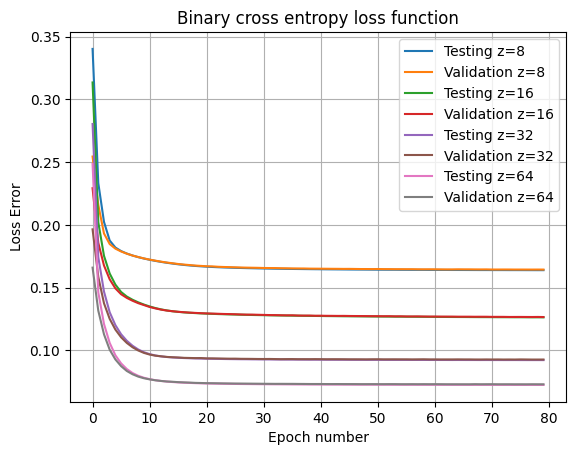

In [7]:
for z in models:
    plt.plot(models[z]["logs"].history['loss'], label='Testing z='+str(z))
    plt.plot(models[z]["logs"].history['val_loss'], label='Validation z='+str(z))

plt.title('Binary cross entropy loss function')
plt.ylabel('Loss Error')
plt.xlabel('Epoch number')
plt.legend(loc="upper right")

plt.grid()

Firstly, we see that our model is robust as the precision on the validation dataset is very similar with the one of the testing dataset, no matter the value z. Thus, we don't have to worry about overfitting.
Secondly, as expected, the more the compress version of an image use data, the more the resulted decoded version is good. Otherwise, a video in 480p on youtube could have a better quality than in 1080p :D

From now on, we will use z=32.

Let's test our model on the test dataset and display some input and output images.

438/438 [==============================] - 0s 554us/step


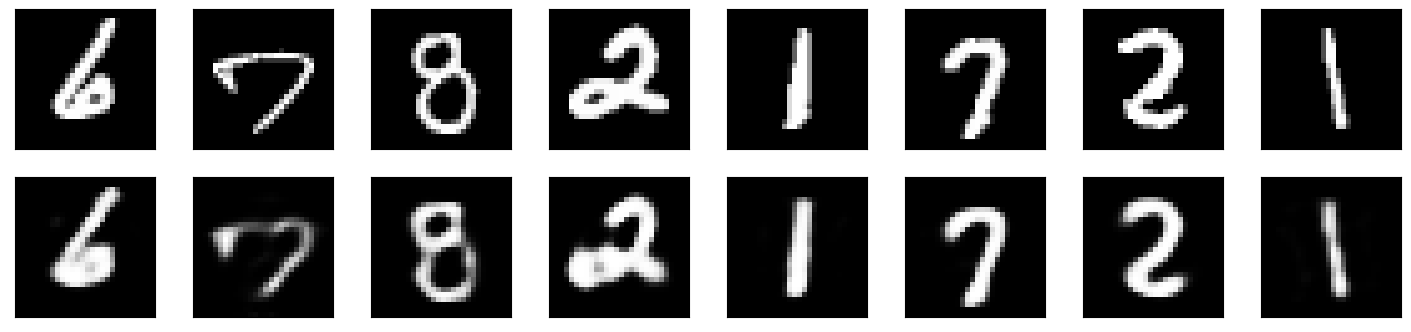

In [11]:
decoded_imgs = models[32]["autoencoder"].predict(copy.deepcopy(X_test))



plt.figure(figsize=(18, 4))
for i in range(8):
  # show reference images (input)
  ax = plt.subplot(2, 8, i + 1)
  plt.imshow(copy.deepcopy(X_test[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # show decoded images (output)
  ax = plt.subplot(2, 8, i + 1 + 8)
  plt.imshow(copy.deepcopy(decoded_imgs[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

The results are pretty good. The input data have a dimension of 28x28 = 784. The latent space here have a dimensionality of 32. So, this model achieves a compression of 1-32/784 = 96%

For curiosity only, we can display the latent vector associated to those test images.
For the same reason the file representing a compress image does not represent anything from a human perspective, the latent space of the autoencoder does not carry visual information.

438/438 [==============================] - 0s 474us/step


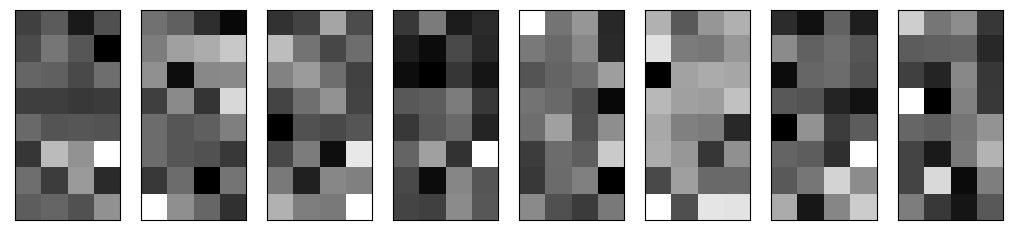

In [14]:
encoded_imgs = models[32]["encoder"].predict(X_test)

plt.figure(figsize=(16, 8))
for i in range(8):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(encoded_imgs[i].reshape(8,4))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### We can improve the precision of our model without changing the compression rate by adding some dense layers.

Our new model will have three dense layers of size 128, 64 and 32.

In [15]:
# Input data size
original_dim = 784
intermediate_dim0 = 128
intermediate_dim1 = 64
latent_dims = 32

epochs=80
batch_size=250


input_img = Input(shape=(original_dim,))

encoded = Dense(intermediate_dim0, activation='relu')(input_img)
encoded = Dense(intermediate_dim1, activation='relu')(encoded)
encoded = Dense(latent_dim, activation='relu')(encoded)

decoded = Dense(intermediate_dim1, activation='sigmoid')(encoded)
decoded = Dense(intermediate_dim0, activation='sigmoid')(encoded)
decoded = Dense(original_dim, activation='sigmoid')(encoded)

autoencoder3 = Model(input_img, decoded)
autoencoder3.compile(optimizer='adam', loss='binary_crossentropy') # you can also use MSE loss function 

encoder3 = Model(input_img, encoded)

encoded_input = Input(shape=(latent_dim,))
decoder3 = Model(encoded_input, decoder_layer(encoded_input))

autoencoder3.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_8 (Dense)             (None, 128)               100480    
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 784)               50960     
                                                                 
Total params: 163,856
Trainable params: 163,856
Non-trainable params: 0
_________________________________________________________________


In [16]:
logs3 = autoencoder3.fit(X_train, X_train,epochs=epochs,batch_size=batch_size,shuffle=True,validation_data=(X_test, X_test))
    

Epoch 1/80
224/224 [==============================] - 1s 3ms/step - loss: 0.2527 - val_loss: 0.1661
Epoch 2/80
224/224 [==============================] - 1s 3ms/step - loss: 0.1426 - val_loss: 0.1281
Epoch 3/80
224/224 [==============================] - 1s 3ms/step - loss: 0.1201 - val_loss: 0.1137
Epoch 4/80
224/224 [==============================] - 1s 3ms/step - loss: 0.1096 - val_loss: 0.1066
Epoch 5/80
224/224 [==============================] - 1s 3ms/step - loss: 0.1042 - val_loss: 0.1024
Epoch 6/80
224/224 [==============================] - 1s 3ms/step - loss: 0.1004 - val_loss: 0.0988
Epoch 7/80
224/224 [==============================] - 1s 3ms/step - loss: 0.0973 - val_loss: 0.0960
Epoch 8/80
224/224 [==============================] - 1s 3ms/step - loss: 0.0947 - val_loss: 0.0939
Epoch 9/80
224/224 [==============================] - 1s 3ms/step - loss: 0.0925 - val_loss: 0.0919
Epoch 10/80
224/224 [==============================] - 1s 3ms/step - loss: 0.0910 - val_loss: 0.0906

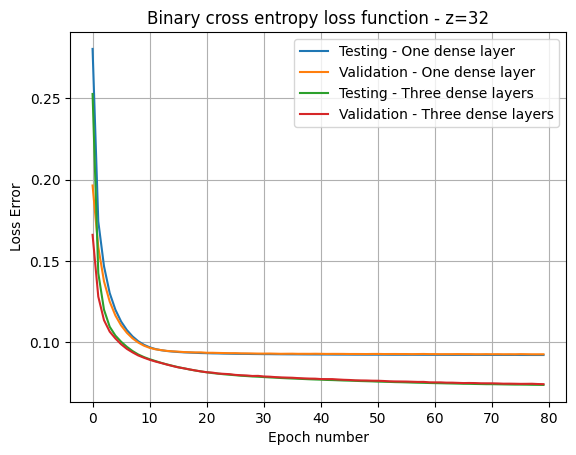

In [17]:
plt.plot(models[32]["logs"].history['loss'], label='Testing - One dense layer')
plt.plot(models[32]["logs"].history['val_loss'], label='Validation - One dense layer')

plt.plot(logs3.history['loss'], label='Testing - Three dense layers')
plt.plot(logs3.history['val_loss'], label='Validation - Three dense layers')

plt.title('Binary cross entropy loss function - z=32')
plt.ylabel('Loss Error')
plt.xlabel('Epoch number')
plt.legend(loc="upper right")

plt.grid()

As we can see, the addition of two layers allows our model to reach a better precision without changing the dimensionality of the latent space.

We also see that the new model take more time to converge. Indeed, with one layer, the total number of parameters that can be train (weights) is 50992. In comparison, with three layers, this number is equal to 163856.

We now display a comparison between the one layer model outputs, and the three layer ones, for the same input images.

438/438 [==============================] - 0s 611us/step


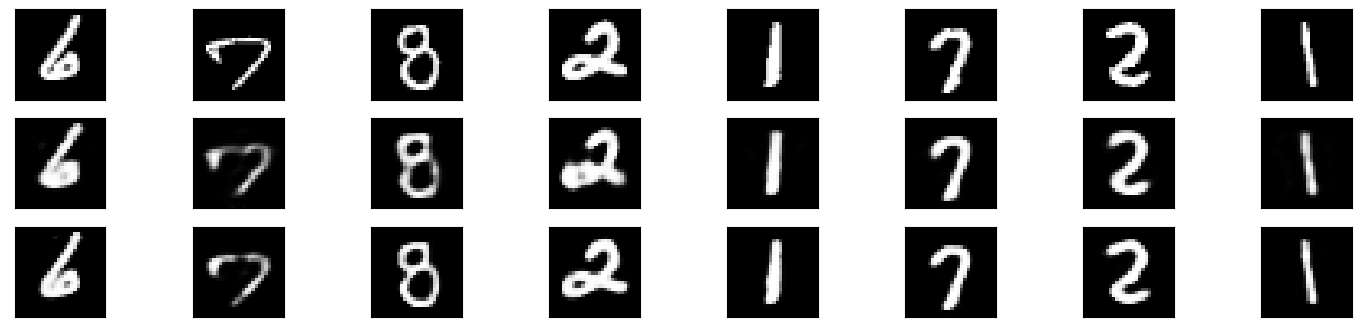

In [18]:
decoded_imgs = models[32]["autoencoder"].predict(copy.deepcopy(X_test))
decoded_imgs3 = autoencoder3.predict(copy.deepcopy(X_test))

plt.figure(figsize=(18, 4))
for i in range(8):
  # show reference images (input)
  ax = plt.subplot(3, 8, i + 1)
  plt.imshow(copy.deepcopy(X_test[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # show decoded images (output) - One layer
  ax = plt.subplot(3, 8, i + 1 + 8)
  plt.imshow(copy.deepcopy(decoded_imgs[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # show decoded images (output) - Three layers
  ax = plt.subplot(3, 8, i + 1 + 2*8)
  plt.imshow(copy.deepcopy(decoded_imgs3[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

Our result are very good. However, for such task, it is common to use convolutional layers (CNN). We decided to build a third model based on this idea.

### Auto-encoder with two convolutional layers

Let's build a auto-encoder from a CNN.
We use the following characteristics :
- Two convolutional layers composed of 32 features with a kernel of size (3,3) followed by :
    - MaxPooling2D (2,2) for encoder (divide by two the dimensionality)
    - UpSampling2D (2,2) for the decoder (double the dimensionality) 
- One last layer of 1 feature with a (3,3) kernel and a sigmoid activation function

The target of this project is to focus on the auto-encoder. We don't show the different tests we made to tune the layers of this CNN model as it is not linked to the understanding of auto-encoder or latent space. Indeed, we just want to show that in such tasks, including the following denoising process, the use of convolutional layer is very relevant.

In [42]:

latent_dims = 32

epochs=80
batch_size=250

width = 28

X_trainIm = X_train.reshape(X_train.shape[0], width, width, 1)
X_testIm  = X_test.reshape(X_test.shape[0], width, width, 1)

input_img = Input(shape=(width,width,1))

encoded = Conv2D(latent_dims,(3,3),activation='relu',padding='same')(input_img)
encoded = MaxPooling2D(pool_size=(2,2),padding='same')(encoded)
encoded = Conv2D(latent_dims,(3,3),activation='relu',padding='same')(encoded)
encoded = MaxPooling2D(pool_size=(2,2),padding='same')(encoded)

decoded = Conv2D(latent_dims,(3,3),activation='relu',padding='same')(encoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(latent_dims,(3,3),activation='relu',padding='same')(decoded)
decoded = UpSampling2D((2,2))(decoded)
decoded = Conv2D(1,(3,3),activation='sigmoid',padding='same')(decoded)

autoencoderConv = Model(input_img, decoded)
autoencoderConv.compile(optimizer='adam', loss='binary_crossentropy')

encoderConv = Model(input_img, encoded)

encoded_input = Input(shape=(latent_dim,))
decoderConv = Model(encoded_input, decoder_layer(encoded_input))

autoencoderConv.summary()

Model: "model_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 7, 7, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 7, 7, 32)          924

In [43]:
logsConv = autoencoderConv.fit(X_trainIm, X_trainIm, epochs=epochs, batch_size=batch_size, shuffle=True,
                validation_data=(X_testIm, X_testIm))

Epoch 1/80
224/224 [==============================] - 32s 139ms/step - loss: 0.1462 - val_loss: 0.0828
Epoch 2/80
224/224 [==============================] - 31s 137ms/step - loss: 0.0789 - val_loss: 0.0760
Epoch 3/80
224/224 [==============================] - 31s 139ms/step - loss: 0.0744 - val_loss: 0.0731
Epoch 4/80
224/224 [==============================] - 31s 138ms/step - loss: 0.0724 - val_loss: 0.0716
Epoch 5/80
224/224 [==============================] - 31s 138ms/step - loss: 0.0711 - val_loss: 0.0707
Epoch 6/80
224/224 [==============================] - 31s 136ms/step - loss: 0.0703 - val_loss: 0.0702
Epoch 7/80
224/224 [==============================] - 30s 134ms/step - loss: 0.0696 - val_loss: 0.0694
Epoch 8/80
224/224 [==============================] - 31s 141ms/step - loss: 0.0691 - val_loss: 0.0689
Epoch 9/80
224/224 [==============================] - 31s 140ms/step - loss: 0.0686 - val_loss: 0.0686
Epoch 10/80
224/224 [==============================] - 31s 138ms/step - l

Let's compare the convergence speed and the precision of our new CNN model.

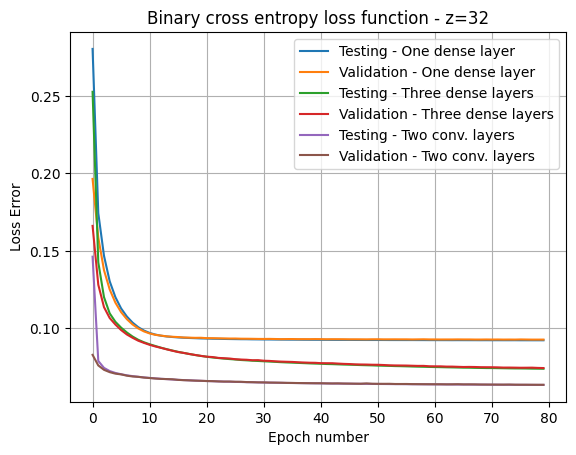

In [45]:
plt.plot(models[32]["logs"].history['loss'], label='Testing - One dense layer')
plt.plot(models[32]["logs"].history['val_loss'], label='Validation - One dense layer')

plt.plot(logs3.history['loss'], label='Testing - Three dense layers')
plt.plot(logs3.history['val_loss'], label='Validation - Three dense layers')

plt.plot(logsConv.history['loss'], label='Testing - Two conv. layers')
plt.plot(logsConv.history['val_loss'], label='Validation - Two conv. layers')

plt.title('Binary cross entropy loss function - z=32')
plt.ylabel('Loss Error')
plt.xlabel('Epoch number')
plt.legend(loc="upper right")

plt.grid()

As expected, the use of convolutional layers allow to reach better result. Also, the number of weight is low in comparison with the other two models (28353) which alows a better converging speed.

By the way, the remark about robustness that we made about the one-dense-layer model is still true for the other ones. As the testing and validation process reach the same precision, we know that there is no overfitting. 


Here follows the comparison of the output images of the three models :
- Input image
- Output image - One dense layer
- Output image - Three dense layers
- Output image - Two convolutional layers

438/438 [==============================] - 2s 4ms/step


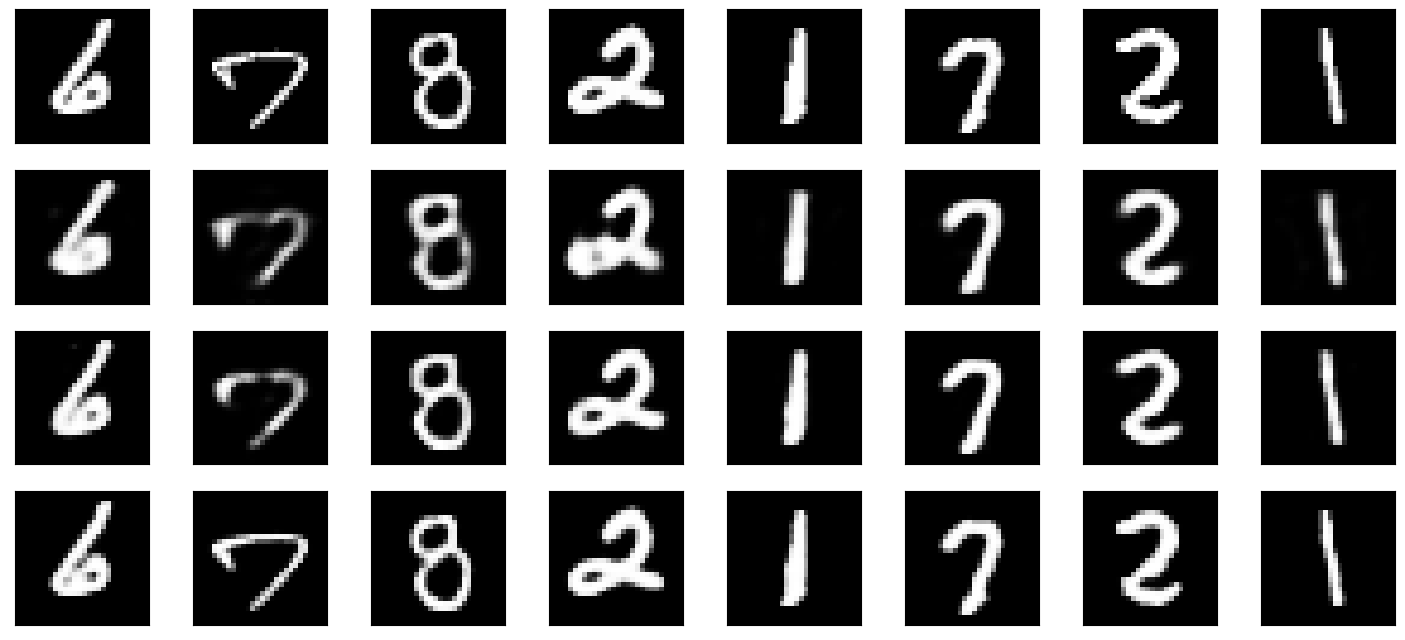

In [46]:
decoded_imgs = models[32]["autoencoder"].predict(copy.deepcopy(X_test))
decoded_imgs3 = autoencoder3.predict(copy.deepcopy(X_test))
decoded_imgsConv = autoencoderConv.predict(copy.deepcopy(X_testIm))

plt.figure(figsize=(18, 8))
for i in range(8):
  # show reference images (input)
  ax = plt.subplot(4, 8, i + 1)
  plt.imshow(copy.deepcopy(X_test[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # show decoded images (output) - One layer
  ax = plt.subplot(4, 8, i + 1 + 8)
  plt.imshow(copy.deepcopy(decoded_imgs[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # show decoded images (output) - Three layers
  ax = plt.subplot(4, 8, i + 1 + 2*8)
  plt.imshow(copy.deepcopy(decoded_imgs3[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # show decoded images (output) - Two conv layers
  ax = plt.subplot(4, 8, i + 1 + 3*8)
  plt.imshow(copy.deepcopy(decoded_imgsConv[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

## 6- Using auto-encoder for image denoising

When we compress an image, we try to keep only the relevant information. If some noise is adding in the input image, it should be 'ignored' by the compression process, that is, the noise should not be considered in the latent vector. Thus, the output image should not contain noise.

We can try this hypothesis. Notice that this time, the model does not try to fit the output image with the input image. Indeed, the input image are noisy. The model tries to fit the clean version of the input image.

In [47]:
# We add noise to our dataset
ratioNoise = 0.5
X_trainIm_noisy = X_trainIm + ratioNoise * np.random.normal(loc=0.0, scale=1.0, size=X_trainIm.shape)
X_testIm_noisy = X_testIm + ratioNoise * np.random.normal(loc=0.0, scale=1.0, size=X_testIm.shape)

X_trainIm_noisy = np.clip(X_trainIm_noisy, 0, 1)
X_testIm_noisy = np.clip(X_testIm_noisy, 0, 1)

# We train our model, using the same previous CNN auto-encoder
logsConvNoise = autoencoderConv.fit(X_trainIm_noisy, X_trainIm, epochs=epochs, batch_size=batch_size, shuffle=True,
                validation_data=(X_testIm_noisy, X_testIm))

Epoch 1/80
224/224 [==============================] - 32s 142ms/step - loss: 0.1553 - val_loss: 0.1236
Epoch 2/80
224/224 [==============================] - 31s 140ms/step - loss: 0.1205 - val_loss: 0.1178
Epoch 3/80
224/224 [==============================] - 33s 145ms/step - loss: 0.1166 - val_loss: 0.1152
Epoch 4/80
224/224 [==============================] - 33s 150ms/step - loss: 0.1143 - val_loss: 0.1136
Epoch 5/80
224/224 [==============================] - 34s 150ms/step - loss: 0.1128 - val_loss: 0.1123
Epoch 6/80
224/224 [==============================] - 33s 149ms/step - loss: 0.1115 - val_loss: 0.1109
Epoch 7/80
224/224 [==============================] - 33s 148ms/step - loss: 0.1104 - val_loss: 0.1098
Epoch 8/80
224/224 [==============================] - 33s 149ms/step - loss: 0.1094 - val_loss: 0.1088
Epoch 9/80
224/224 [==============================] - 33s 147ms/step - loss: 0.1085 - val_loss: 0.1081
Epoch 10/80
224/224 [==============================] - 33s 148ms/step - l

Let's plot the evolution of the precision during the training.

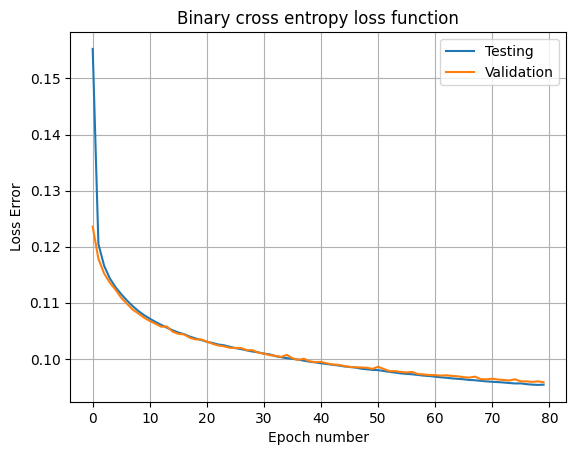

In [55]:
plt.plot(logsConvNoise.history['loss'], label='Testing')
plt.plot(logsConvNoise.history['val_loss'], label='Validation')
plt.title('Binary cross entropy loss function')
plt.ylabel('Loss Error')
plt.xlabel('Epoch number')
plt.legend(loc="upper right")

plt.grid()
plt.show()

We see that the converging time is longer than for the previous task. This is due to the higher complexity of the task.

Also, the obtained precision is very good. Even with such noisy image, our model can reach a performance similar to the ones of the previous part.

We can now display the original image, its noisy version and the output image, after the denoising process.

438/438 [==============================] - 2s 4ms/step


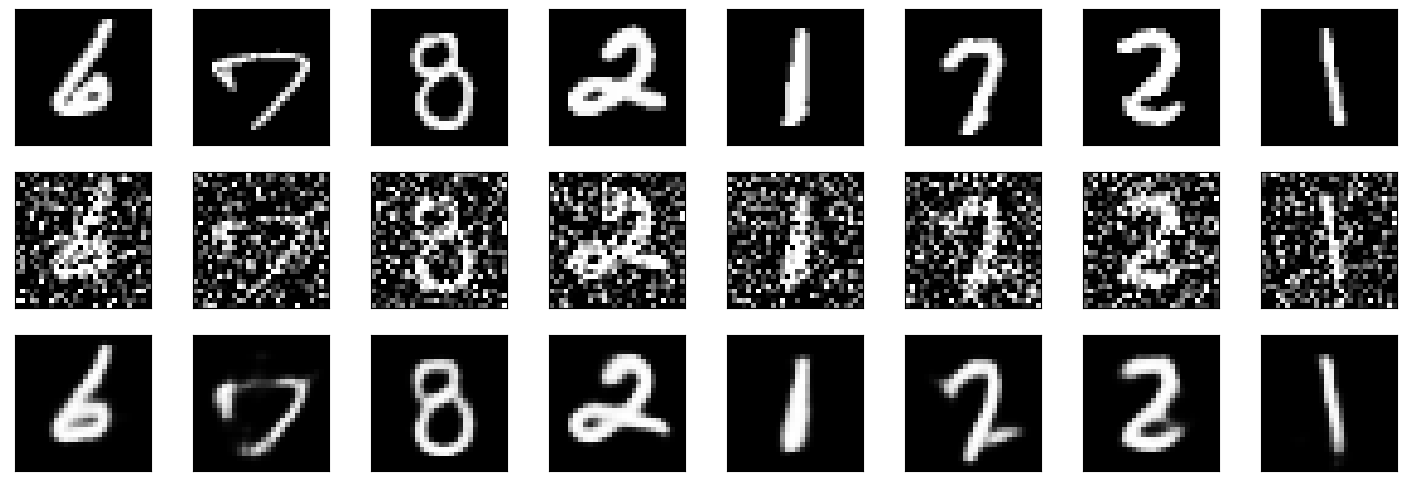

In [56]:
decoded_imgsConvNoise = autoencoderConv.predict(copy.deepcopy(X_testIm_noisy))

plt.figure(figsize=(18, 6))
for i in range(8):
  # show reference images (input)
  ax = plt.subplot(3, 8, i + 1)
  plt.imshow(copy.deepcopy(X_test[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # show decoded images (output) - One layer
  ax = plt.subplot(3, 8, i + 1 + 8)
  plt.imshow(copy.deepcopy(X_testIm_noisy[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # show decoded images (output) - Three layers
  ax = plt.subplot(3, 8, i + 1 + 2*8)
  plt.imshow(copy.deepcopy(decoded_imgsConvNoise[i]).reshape(28, 28))
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

plt.show()

The results are not perfect but still impressive. The ability of an autoencoder to compress the input images is thus very powerful as a denoising process.

## Latent space and style transfer





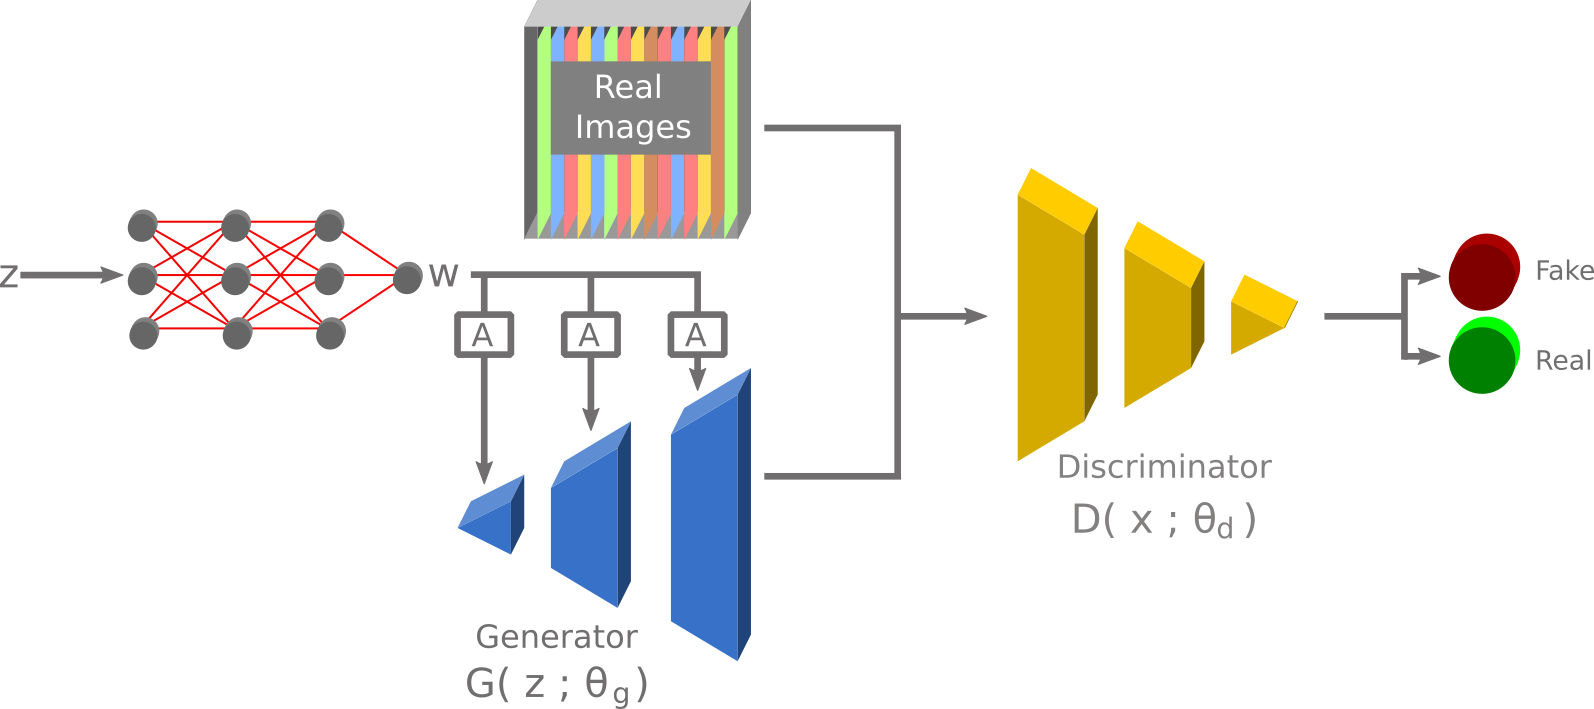

In StyleGAN2, each generator layer is fed a specific latent variable through linear projection (as shown in the image above). The first layers are responsible for the global appearance of the output image, while the last ones focus on finer details.

Let's import two images, one used as a content, and one used its style.

In [60]:
# Function that download and preprocess an image.
def getImage(img_url,img_size):
    img = tf.io.decode_image(
        tf.io.read_file(tf.keras.utils.get_file(os.path.basename(img_url)[-128:], img_url)),
        channels=3, dtype=tf.float32)[tf.newaxis, ...]

    # Obtaining square image through cropping
    new_shape = min(img.shape[1], img.shape[2])
    offset_y = max(img.shape[1] - img.shape[2], 0) // 2
    offset_x = max(img.shape[2] - img.shape[1], 0) // 2
    img = tf.image.crop_to_bounding_box(img, offset_y, offset_x, new_shape, new_shape)
    img = tf.image.resize(img, (img_size, img_size), preserve_aspect_ratio=True)
    return img




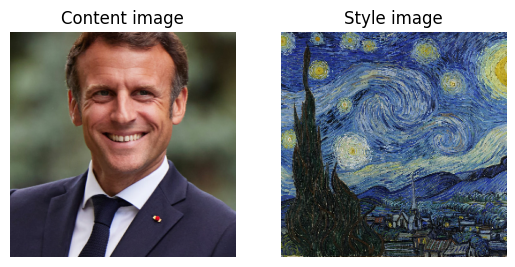

In [61]:

output_img_size = 400 # Can be modified
style_img_size = 256  # Corresponds to the size of the image used to train the model

content_img_url = 'https://upload.wikimedia.org/wikipedia/commons/d/d2/Emmanuel_Macron_June_2022_%28cropped%29.jpg'
content_img = getImage(content_img_url,output_img_size)

style_img_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg'
style_img = getImage(style_img_url,style_img_size)

# Display the images
plt.figure()

plt.subplot(1,2,1)
plt.imshow(content_img[0])
plt.title("Content image")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(style_img[0])
plt.title("Style image")
plt.axis('off')

plt.show()


We use a TF hub module to import a pretrained model and feed it with our images. The model will compute the latent vector of the two images.

Then, it will create a new latent vector whose the first half corresponds to the first half of the style image latent vector. The second half correspond to the second half of the content image latent vector.

Finally, the decoder part of the model will be feed with this new latent vector.

Basically, this latent vector have the finner detail of Macron but the style of the Starry Night.

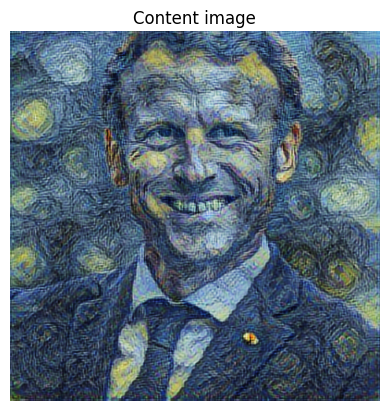

In [62]:
tf_hub = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

output = tf_hub(tf.constant(content_img), tf.constant(style_img))
stylized_img = output[0]

plt.figure()

plt.imshow(stylized_img[0])
plt.title("Content image")
plt.axis('off')

plt.show()


The resulting image show well the difference between the first and the late values of the latent vector associated to a picture.

With the used model, the global appearance of a picture is encoded in the first values of the latent vector of an image. As we are using the first values of Starry Night's latent vector, the resulting image has the same "style". Here, we really see that the texture of the style image is used on the content image.

In the opposite, the last values of the latent vector code for finer details. Here the face and the shape of Macron is well present. However, the blurred background has disapeared.

In the following section, we show other examples.

We hope this project showed you the power of the auto-encoders and gave you an intuition about what are the latent vectors.

Happy new year!

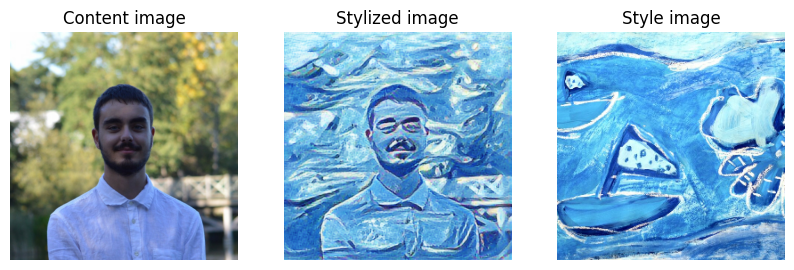

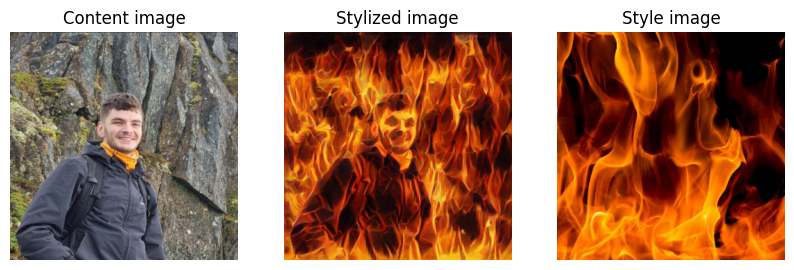

9717983/9717983 [==============================] - 4s 0us/step


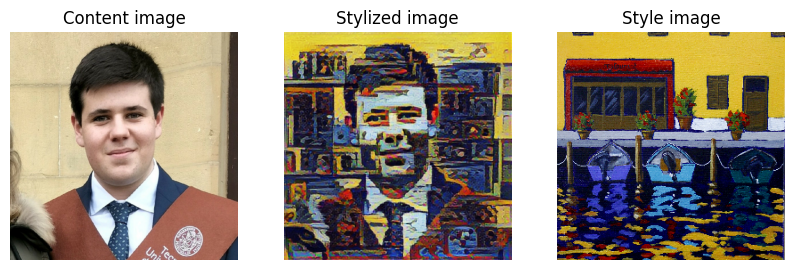

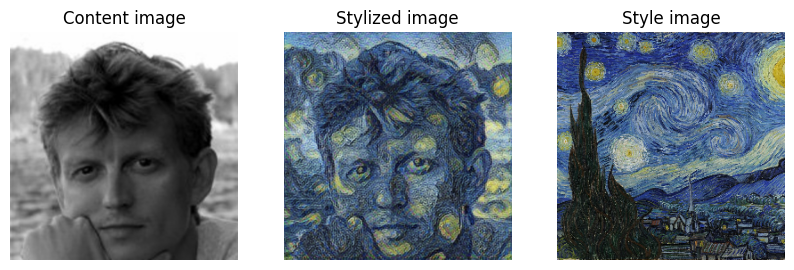

In [94]:
content_img = getImage('https://i.ibb.co/hsV9yQs/LOUIS-FR-NEAU.jpg',output_img_size)
style_img = getImage('https://www.paintedpaperart.com/wp-content/uploads/2022/05/5396009562_06ba085b0a_o-1024x611.jpg',style_img_size)
stylized_img = tf_hub(tf.constant(content_img), tf.constant(style_img))[0]
plt.figure(figsize=(10,4))
plt.subplot(1,3,1),plt.imshow(content_img[0]),plt.title("Content image"),plt.axis('off')
plt.subplot(1,3,2),plt.imshow(stylized_img[0]),plt.title("Stylized image"),plt.axis('off')
plt.subplot(1,3,3),plt.imshow(style_img[0]);plt.title("Style image");plt.axis('off');plt.show()

content_img = getImage('https://i.ibb.co/GRHz6dG/h-h-Capture-d-cran-2022-12-30-025353.png',output_img_size)
style_img = getImage('https://rescue18.fr/wp-content/uploads/2020/04/flammes.jpg',style_img_size)
stylized_img = tf_hub(tf.constant(content_img), tf.constant(style_img))[0]
plt.figure(figsize=(10,4))
plt.subplot(1,3,1),plt.imshow(content_img[0]),plt.title("Content image"),plt.axis('off')
plt.subplot(1,3,2),plt.imshow(stylized_img[0]),plt.title("Stylized image"),plt.axis('off')
plt.subplot(1,3,3),plt.imshow(style_img[0]);plt.title("Style image");plt.axis('off');plt.show()

content_img = getImage('https://i.ibb.co/kGt9pzS/oui1664277434909.jpg',output_img_size)
style_img = getImage('https://da32ev14kd4yl.cloudfront.net/versioned/milone-art-academy/images/marine-coloriste-acrylique-tableau.JPG',style_img_size)
stylized_img = tf_hub(tf.constant(content_img), tf.constant(style_img))[0]
plt.figure(figsize=(10,4))
plt.subplot(1,3,1),plt.imshow(content_img[0]),plt.title("Content image"),plt.axis('off')
plt.subplot(1,3,2),plt.imshow(stylized_img[0]),plt.title("Stylized image"),plt.axis('off')
plt.subplot(1,3,3),plt.imshow(style_img[0]);plt.title("Style image");plt.axis('off');plt.show()

content_img = getImage('https://i1.rgstatic.net/ii/profile.image/272281872105501-1441928465784_Q512/Evgeny-Osipov-3.jpg',output_img_size)
style_img = getImage('https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',style_img_size)
stylized_img = tf_hub(tf.constant(content_img), tf.constant(style_img))[0]
plt.figure(figsize=(10,4))
plt.subplot(1,3,1),plt.imshow(content_img[0]),plt.title("Content image"),plt.axis('off')
plt.subplot(1,3,2),plt.imshow(stylized_img[0]),plt.title("Stylized image"),plt.axis('off')
plt.subplot(1,3,3),plt.imshow(style_img[0]);plt.title("Style image");plt.axis('off');plt.show()